# Machine Learning Final Project - QM/MM Trajectory Analysis for a Chemical Reaction

By Anthony Bogetti

In [1]:
# Imports
import numpy as np
import pandas as pd
import mdtraj as md
import h5py
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Initial Test:

In [3]:
# Prepare the atomic coordinates
t = md.load("test.pdb") # Loading in a single frame as a test
topology = t.topology
print(topology.select('resid 0 to 1'))
topology = t.topology
coords = t.xyz[:,0:37]
coords = np.squeeze(coords)
print(coords.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
(37, 3)


In [4]:
atom_indices = np.array([[15, 3, 0, 1],
                [15, 3, 0, 2],
                [11, 3, 0, 1],
                [11, 3, 0, 2],
                [4, 1, 0, 2],
                [4, 1, 0, 3],
                [8, 1, 0, 2],
                [8, 1, 0, 3],
                [20, 2, 0, 1],
                [20, 2, 0, 3],
                [22, 2, 0, 1],
                [22, 2, 0, 3]
               ])
print(atom_indices.shape)
dihedrals = np.squeeze(np.degrees(md.compute_dihedrals(t, atom_indices)))
print(dihedrals)

(12, 4)
[143.67911  -42.09825  -25.00117  149.22145  147.9005   -37.66518
 -32.63398  141.80034  158.10623  -16.045063 -31.84342  154.00526 ]


In [5]:
# Compute the condensed distance matrix
distmat = pdist(coords, 'euclidean') # These will be the features used to train my model
print(distmat.shape)

(666,)


In [6]:
from itertools import combinations 
noH = [0,1,2,3,4,5,6,7,8,11,12,13,14,15,20,21,22,23,24,34,35,36]
print(topology.select('resid 0 to 1')[noH])
noHcoords = []
for i in noH:
    coord = t.xyz[:,i]
    noHcoords.append(coord)
noHcoords = np.squeeze(np.array(noHcoords))
print(noHcoords.shape)
perm = combinations(noH,3) 
a = np.array(list(perm))
#print(a)
angles = []
for i in a:
    #print(i)
    mask = coords[i]
    d1 = mask[0] - mask[1]
    d2 = mask[2] - mask[1]
    cosine_angle = np.dot(d1, d2) / (np.linalg.norm(d1) * np.linalg.norm(d2))
    angle = np.arccos(cosine_angle)
    angles.append(np.degrees(angle))
angles = np.array(angles)
print(angles)

[ 0  1  2  3  4  5  6  7  8 11 12 13 14 15 20 21 22 23 24 34 35 36]
(22, 3)
[ 30.526268  31.26551  121.82448  ...  70.269966  72.69045  176.44257 ]


## To Do:
1. w_crawl to get distmat for all data points (Done): this was time-consuming but not difficult, I end up with a "condensed" array of pairwise distance combinations between all of the 37 atoms in the system in Angstroms.
2. Determine which data points are part of pathways that lead to products (Done): this was also not tricky, and didn't take too much time, I ran w_succ to get all of the successful trajectories and then used w_trace to get all of the conformations in the past along the successful conformation pathways, deleted the repeated entries and then for each iter:seg combo assigned a 1 if the pair is in the successful list and a 0 if not.
3. Build main pandas dataset (Done)
4. Train model using lasso/random forest and examine importance of each pairwise distance leading to each outcome: This worked almost too well... I need to look more into it to see if I did anything wrong but so far it is very promising!

In [8]:
# Load in my hdf5 data file
h5file = h5py.File("west.h5", "r")
h5file.keys()

OSError: Unable to open file (unable to open file: name = 'west.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
id_list = []
weight_list = []
success_list = []
distmat_list = []
angle_list = []
for i in range(1,1001):
    sweights = "iterations/iter_" + str(i).zfill(8) + "/seg_index"
    ssuccess = "iterations/iter_" + str(i).zfill(8) + "/auxdata/success"
    sdistmat = "iterations/iter_" + str(i).zfill(8) + "/auxdata/distmat"
    sangles = "iterations/iter_" + str(i).zfill(8) + "/auxdata/angles"

    weights = h5file[sweights][:]['weight']
    successes = h5file[ssuccess][:,0]
    distmats = h5file[sdistmat][:]
    angles = h5file[sangles][:]


    n_segs = weights.shape[0]
    for j in range(1,n_segs):
        id = str(i).zfill(4) + str(j).zfill(4)
        weight = weights[j]
        success = successes[j]
        distmat = distmats[j]
        angle = angles[j]
        id_list.append(id)  
        weight_list.append(weight)
        success_list.append(int(success))
        distmat_list.append(distmat)
        angle_list.append(angle)

In [5]:
n = np.array(distmat_list)
#n2 = np.array(angle_list)

In [1]:
from itertools import combinations 
import numpy as np
atoms = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'H1', 'H2', 'C10', 'C11', 'C12', 'C13', 'C14', 'H3', 'H4', 'H5', 'H6', 'C15', 'C16', 'C17', 'C18', 'C19', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'N1', 'N2', 'N3']
perm = combinations(atoms,2) 
a = np.array(list(perm))
print(a)

noH = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'N1', 'N2', 'N3']
perm2 = combinations(noH,3) 
a2 = np.array(list(perm2))
print(a2.shape)

[['C1' 'C2']
 ['C1' 'C3']
 ['C1' 'C4']
 ...
 ['N1' 'N2']
 ['N1' 'N3']
 ['N2' 'N3']]
(1540, 3)


In [7]:
mydata = pd.DataFrame()
mydata['ID'] = id_list
mydata['weight'] = weight_list
mydata['success'] = success_list
for i in range(0,666):
    if 'H' in a[i,0]:
        continue
    elif 'H' in a[i,1]:
        continue
    else:
        fname = 'b' + str(a[i,0]) + '-' + str(a[i,1])
        mydata[fname] = n[:,i]
mydata.to_csv("mydata.csv")

#for i in range(0,a2.shape[0]):
#        fname = 'a' + str(a2[i,0]) + '-' + str(a2[i,1]) + '-' + str(a2[i,2])
#        mydata[fname] = n2[:,i]
#mydata.head

In [ ]:
# Split dataset into training and test
from sklearn.model_selection import train_test_split
X = mydata.iloc[:,3:234]
X_1 = mydata.iloc
y = mydata.iloc[:,2]
W = mydata.iloc[:,1]/1000
Xtrain, Xtest, ytrain, ytest, Wtrain, Wtest = train_test_split(X, y, W, test_size=0.25, random_state=None)

In [ ]:
# Correlation matrix for all non H-contining features
names = Xtrain.columns
correlations = Xtrain.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
#ticks = np.arange(1,232,1)
#ax.set_xticks(ticks)
#ax.set_yticks(ticks)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
plt.show()

In [ ]:
Sc = StandardScaler()
X = Sc.fit_transform(Xtrain)
pca = PCA(5)
pca_data = pd.DataFrame(pca.fit_transform(X), columns=['Pc1', 'Pc2', 'Pc3', 'Pc4', 'Pc5'])

# Cluster the fingerprints and add the cluster labels to the dataframe with the PCs
kmeans = KMeans(n_clusters=3).fit(X)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)

#pca_data['C6-C10'] = mydata['C6-C10']

# Plot the first two PCs colored by the cluster labels
pca_data.plot(kind='scatter', x='Pc1', y='Pc2', c='cluster', cmap='jet')

In [ ]:
# Fit model and make predictions
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=0)

# For no weights, just remove Wtrain
rfc.fit(Xtrain, ytrain, Wtrain)
predictions = rfc.predict(Xtest)

In [ ]:
# Evaluate our model
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
acc = rfc.score(Xtest,ytest)
print("Overall accuracy:", acc)
yscore = rfc.predict_proba(Xtest)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(ytest, yscore)

roc_auc = dict()
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [ ]:
# Plot feature importance
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0,0,1,1])
importances = list(rfc.feature_importances_)
for i, num in enumerate(importances):
    #print(Xtrain.columns[i], num)
    if num == 0:
        continue
    elif num > 0.02:
        ax.bar(Xtrain.columns[i], num, color='tomato')
    else:
        ax.bar(Xtrain.columns[i], num, color='dodgerblue')
        
plt.xticks(rotation=90)
left, width = .25, .725
bottom, height = .25, .7
right = left + width
top = bottom + height
#ax.text(right, top, 'Random Forest Feature Importance',
#        horizontalalignment='right',
#        verticalalignment='top',
#        fontsize=40,
#        transform=ax.transAxes)
plt.show()

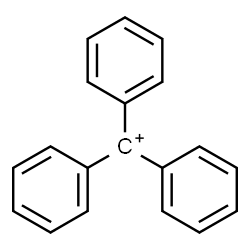

The C-N atomic distances are not too surprising.  However, the C1-C3/C1-C2 distances are!  I'll try to take a closer look at those.

In [ ]:
# Histogram the C1C3 distances to see what's going on
C1C3 = mydata.iloc[:,4]
n, bins, patches = plt.hist(C1C3, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

Nothing too surprising there...

In [ ]:
# Split the C1C3 distance dataset into successful and unsuccessful parts
C1C3_slist = []
C1C3_ulist = []

for i,row in mydata.iterrows():
    s = row['success']
    if s == 1:
        C1C3_slist.append(row['C7-C10'])
    else:
        C1C3_ulist.append(row['C7-C10'])


In [ ]:
# Histogram the successful and unsuccessful datapoints' C1C3 distances separately
n, bins, patches = plt.hist(C1C3_ulist, 50, density=True, facecolor='gold', alpha=0.4)
n, bins, patches = plt.hist(C1C3_slist, 50, density=True, facecolor='dodgerblue', alpha=0.4)
plt.show()

This is interesting!  For the "successful" trajectories, the C-C bond length of the cation to the neighboring carbon is slightly longer (on average) as seen in the histogram.  This actually makes sense because a hybridization change from sp2 to sp3 should result in a slightly longer bond length (actually, one of 1.54 Angstroms!).  Both of these most probable distances match literature values (https://cdnsciencepub.com/doi/pdf/10.1139/v86-174).